## **Diffusion Equation**

$$
\frac{d\Sigma}{dt} = \frac{3}{r}\frac{\partial}{\partial r} \left[r^{1/2} \frac{\partial}{\partial r}(\nu \Sigma r^{1/2})\right]
$$

This is evolution equation for the surface density of a geometrically thin disk

Putting this in the form of a diffusion equation:

$$
\frac{\partial f}{\partial t} = D \frac{\partial^2 f}{\partial X^2}
$$
where $X \equiv 2r^{1/2}$, $f \equiv \frac{3}{2}\Sigma X$ and $D = \frac{12\nu}{X^2}$


We need numerical values for $\nu$
$$
\nu = \alpha c_s H \\
H = \frac{c_s}{\Omega} \\
\Omega = \sqrt{\frac{G*M_s}{r^3}} \\
c_s = \sqrt{\frac{k_B * T}{\mu * mH}} \\
mH = \frac{1}{N_A} \\
\mu = 2.3 \\
$$

The Temperature profile is given by:
$$
2 \sigma_b T_{disk}^4 = \frac{9}{4}\Sigma \nu \Omega^2\\
T^3 = \frac{9}{8\sigma_b}\Sigma \frac{k_b \alpha}{\mu mH}\sqrt{\frac{GM}{r^3}}
$$

The Pressure is given by:

$$
P = \frac{c_s^2\Sigma}{H} = c_s\Sigma\Omega
$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import pandas as pd
import os

In [3]:
#Natural Constants

# T = 600 # Temperature
mu = 2.2 # mean molar mass in disk
avog = 6.02214 * 10**23 # avogadros number
mH = 1.673534 * 10**-27 # atomic hydrogen mass
kB = 1.380649 * 10**-23 #boltzmann constant
G = 6.6738 * 10**-11 #gravitational constant
Ms = 1.9886 * 10**30 #solar mass
Me = 5.972 * 10 **24 #earth mass
AU = 1.4959787 * 10**11 #astronomical units
yrs2sec = 3.1536 * 10**7 #convert years to seconds
sb = 5.6704*10**-8

In [4]:
#Disk Parameters
alpha1 = 1.0 * 10**-2
alpha2 = 1.0 * 10**-3
alpha3 = 1.0 * 10**-4
alphas = [alpha1, alpha2, alpha3]
rin = 0.05 * AU #inner radius of the disk
rout = 30 * AU #outer radius of the disk
sigma_in  = 2 * 10**5 #boundary condition at t=0
sigma_max = sigma_in*2 #boundary condition at t=final_time
sigma_min = 1 * 10**2
distance = rout - rin #distance from inner radius to outer radius

In [5]:
#File settings
home_dir = '~/git/surf_2021/'
output_dir = os.path.join(home_dir, 'outputs/')
filename = 'outputs/disk_'
is_saveresults = True

In [6]:
#Temporal discretization
max_years = 1000
dyr = 1
dt = dyr * yrs2sec #timestep
final_time = max_years*yrs2sec #total diffusion time in seconds

In [7]:
#Spacial discretization

n = 600 #number of steps / number of points to plot
dr = distance/n #distance between each spacial step

In [8]:
#Plotting axes
x = np.linspace(rin + dr/2, rout - dr/2, n)
t = np.arange(0, final_time, dt*max_years/n)

In [9]:
#Initialize grid spaces

dist = np.empty(n)
Omega = np.empty(n)
nu = np.empty(n)
X = np.empty(n)
D = np.empty(n)
sigma = np.empty(n)
df_dt = np.empty(n)
f = np.empty(n)
cs2 = np.empty(n)
temp = np.empty(n)
press = np.empty(n)

In [10]:
#Values that are saved

sigma_evol = []
temp_evol = []
press_evol = []

In [11]:
#Boundary Conditions

f_in = 0
f_out = 0

In [12]:
# @numba.njit
def calc_init_params(alpha):
    """
    Calculate the initial parameters values for time t = 0 and changing radius.
    """
    for i in range(n):
        dist[i] = (rin + (rout-rin)*i/(n-1))
        sigma[i] = sigma_in * AU / dist[i]
        if (sigma[i]>sigma_max):
            sigma[i] = sigma_max
        if (dist[i]/AU > 15):
            sigma[i] = sigma_min
        X[i] = 2 * np.sqrt(dist[i])
        Omega[i] = np.sqrt(G * Ms / (dist[i] ** 3))
        temp[i] = ((9*sigma[i]*kB*alpha*Omega[i])/(8*sb*mu*mH))**(1/float(3))
        cs2[i] = (kB * temp[i])/(mu*mH)
        nu[i] = alpha*cs2[i]/Omega[i]
        D[i] = 12 * nu[i] / (X[i] ** 2)
        f[i] = (1.5 * X[i] * sigma[i])

In [13]:
def calc_temp(f, alpha):
    for i in range(n):
        temp[i] = ((9*sigma[i]*kB*alpha*Omega[i])/(8*sb*mu*mH))**(1/float(3))
    return temp

In [14]:
# @numba.njit
def calc_press(f, alpha, T):
    """Calculate the pressure evolution at each dt at each  r"""
    for j in range(n):
        cs2[j] = (kB * temp[j])/(mu*mH)
        press[j] = np.sqrt(cs2[j])*sigma[j]*Omega[j]
    return press

In [15]:
# @numba.njit
def calc_sigma_evol(f, alpha, year):
    """Outputs the surface density at a specific year"""
    for j in range(1, n-1):
        dX1 = X[j] - X[j-1]
        dX2 = X[j+1] - X[j]
        D1 = 0.5 * (D[j] + D[j-1])
        D2 = 0.5 * (D[j+1] + D[j])
        df_dt[j] = D1 * ((-(f[j] - f[j-1])/dX1**2)) + D2 * ((f[j+1]-f[j])/dX2**2)
    dX_final = X[-1]-X[-2]
    dX_in = X[1]-X[0]
    df_dt[0] = D[0] * (-(f[0] - f_in)/dX_in**2 + (f[1]-f[0])/dX_in**2)
    df_dt[n-1] = D[n-1] * (-(f[n-1] - f[n-2])/dX_final**2 + (f_out-f[n-1])/dX_final**2)
    f_new = f + df_dt * dt
    return f_new

In [16]:
def convert_f2sigma(f_new):
    sigma_at_time = [2*f_new[k]/(3*X[k]) for k in range(n)]
    return sigma_at_time

In [17]:
# @numba.njit
def calc_time_evol(f, alpha, year):
    """Outputs the surface density at a specific year"""
    for i in range(1, len(t)):
        f_new = calc_sigma_evol(f, alpha, year)
        T = calc_temp(f_new, alpha)
        P = calc_press(f_new, T, alpha)
        sigma = convert_f2sigma(f_new)
        f = f_new
        if (is_saveresults):
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            np.savetxt(filename + str(i) + '.txt', [f_new, T, P], delimiter=',', newline='\n')# if you want to save results to file
            sigma_evol.append(sigma)
            temp_evol.append(T)
            press_evol.append(P)
    return sigma_evol

In [18]:
def calc_mass_evol(f, alpha, year):
    """Calculate the mass at a specific year"""
    sigma_evol = calc_time_evol(f, alpha, year)
    for j in range(n):
        disk_mass += 2 * np.pi * dist[j] * dr * sigma_evol[j] #mass of disk at t=year
    print(f'The mass of the disk is {disk_mass}.')
    return disk_mass

In [19]:
def plot_sigma_evol(f, alpha, year):
    %matplotlib
    for i in range(year):
        calc_sigma_evol(f, alpha, i)
        plt.figure(1)
        plt.plot(x/AU, sigma_at_time)
        plt.title('Surface Density Evolution of Protoplanetary Disk')
        plt.xlabel('Radius (AU)')
        plt.ylabel('Surface Density')
        plt.xscale('log')
        plt.yscale('log')
        plt.show()
        plt.pause(0.01)

In [20]:
def plot_temp_evol(f, alpha, year):
    %matplotlib
    for i in range(year):
        temp_at_time = calc_temp_evol(f, alpha, year)
        plt.figure(4)
        plt.plot(x/AU, temp_at_time)
        plt.title('Temperature Evolvution in Protoplanetary Disk')
        plt.xlabel('radius (AU)')
        plt.ylabel('Temperature (K)')
        plt.yscale('log')
        plt.show()

In [21]:
def plot_mass_evol(f, alpha, year):
    %matplotlib
    _ = calc_time_evol(f, alpha, year)
    for i in range(year):
        mass_at_time = calc_mass_evol(f, alpha, i)
        plt.figure(2)
        plt.plot(t/yrs2sec, mass_at_time)
        plt.title('Conservation of Mass of an Evolving Protoplanetary Disk')
        plt.xlabel('Time (yrs)')
        plt.ylabel('Total Mass (kg)')
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

In [22]:
def plot_press_evol(f, alpha, year):
    %matplotlib
    _ = calc_time_evol(f, alpha, year)
    for i in range(year):
        press_at_time = press_evol[i]
        plt.figure(3)
        plt.plot(x/AU, press_at_time)
        plt.title('Pressure Evolution of Protoplanetary Disk')
        plt.xlabel('Radius (AU)')
        plt.ylabel('Pressure')
        plt.yscale('log')
        plt.show()
        plt.pause(0.01)

In [23]:
calc_init_params(alpha1)
# calc_time_evol(f, alpha1, 10)

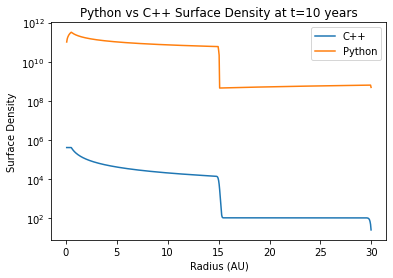

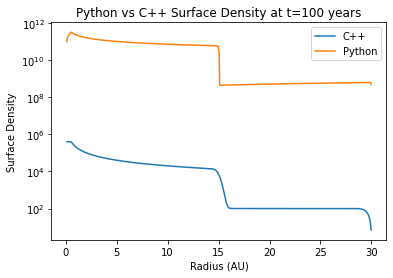

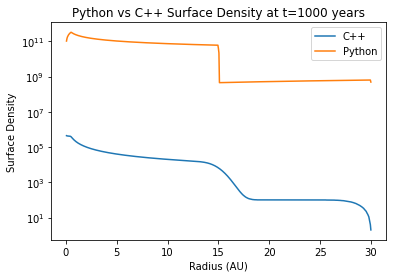

In [24]:
#Compare C++ code to Python code
telapsed = [10, 100, 1000]
count = 0
for time in telapsed:
    df = pd.read_csv('case/radial_' + str(time) + '.txt', delimiter='\t', header=None)
    sigma_c = df[1].to_numpy().astype(np.int)
    sigma_py = calc_sigma_evol(f, alpha2, time)
    plt.title(f'Python vs C++ Surface Density at t={time} years')
    plt.xlabel('Radius (AU)')
    plt.ylabel('Surface Density')
    plt.yscale('log')
    plt.plot(x/AU, sigma_c, label='C++')
    plt.plot(x/AU, sigma_py, label='Python')
    plt.legend()
    plt.show()

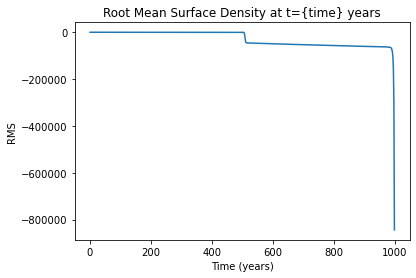

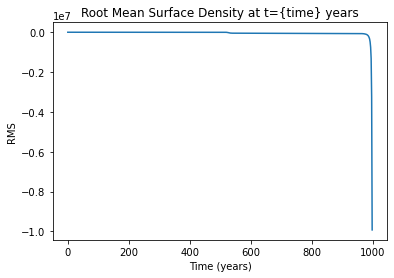

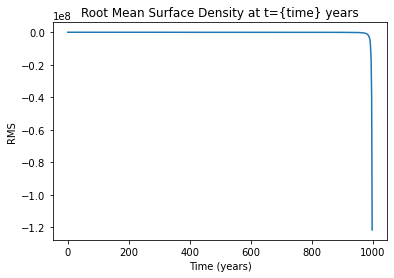

In [25]:
#Plot RMS of Python vs C++
telapsed = [10, 100, 1000]
count = 0
for time in telapsed:
    df = pd.read_csv('case/radial_' + str(time) + '.txt', delimiter='\t', header=None)
    sigma_c = df[1].to_numpy().astype(np.int)
    sigma_py = calc_sigma_evol(f, alpha2, time)
    rms = (sigma_c - sigma_py)/(sigma_c ** 2)
    plt.title('Root Mean Surface Density at t={time} years')
    plt.xlabel('Time (years)')
    plt.ylabel('RMS')
    plt.plot(t/yrs2sec, rms)
    plt.show()

In [26]:
# def plot_time_evol(f, df_dt, dist, alpha):
#     %matplotlib
#     for i in range(1, len(t) + 1):
#         plt.clf
#         for j in range(1, n-1):
#             dX1 = X[j] - X[j-1]
#             dX2 = X[j+1] - X[j]
#             D1 = 0.5 * (D[j] + D[j-1])
#             D2 = 0.5 * (D[j+1] + D[j])
#             df_dt[j] = D1 * ((-(f[j] - f[j-1])/dX1**2)) + D2 * ((f[j+1]-f[j])/dX2**2)
#         dX_final = X[-1]-X[-2]
#         dX_in = X[1]-X[0]
#         df_dt[0] = D[0] * (-(f[0] - f_in)/dX_in**2 + (f[1]-f[0])/dX_in**2)
#         df_dt[n-1] = D[n-1] * (-(f[n-1] - f[n-2])/dX_final**2 + (f_out-f[n-1])/dX_final**2)
#         f = f + df_dt * dt
#         sigma_evol = [2*f[k]/(3*X[k]) for k in range(n)] #surface density at each radius at time t=i
#         disk_mass = np.sum([2 * np.pi * dist[k] * dr * sigma_evol[k] for k in range(n)]) #mass of disk at t=i
#         mass_evol.append(disk_mass)
#         plt.figure(1)
#         plt.plot(x/AU, sigma_evol)
#         plt.title('Surface Density Evolution of Protoplanetary Disk')
#         plt.xlabel('Radius (AU)')
#         plt.ylabel('Surface Density')
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.show()
#         plt.pause(0.01)
#     plt.figure(2)
#     plt.plot(t/yrs2sec, mass_evol)
#     plt.title('Conservation of Mass of an Evolving Protoplanetary Disk')
#     plt.xlabel('Time (yrs)')
#     plt.ylabel('Total Mass (kg)')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.show()
#     print(f'The mass of the disk is {mass_evol[0]}\n')